In [3]:
import os
import cv2
import torch
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, utils

In [ ]:
train_data = datasets.CIFAR10('CIFAR10', train = True, 
                         transform = transforms.Compose([transforms.ToTensor()]),
                         download = True)

train_batch = torch.utils.data.DataLoader(train_data, batch_size = 100, shuffle = True)

In [4]:
def latent_space_vectors(size): #size is the number of samples in a batch
    return torch.randn(size, 100, 1, 1).to(device)

def real_data_target(size):
    return (torch.ones(size)).to(device)

def fake_data_target(size):
    return (torch.zeros(size)).to(device)

In [5]:
#generator will input a random noise of 100 (as usual) and the conditioned on the grayscale image (100, 1, 32, 32)
#y is random noise and x in condition

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        #UPSAMPLE RANDOM NOISE
        
        self.rand1 = nn.ConvTranspose2d(100, 128, kernel_size = 4, stride = 1, padding = 0)#4x4
        self.rand2 = nn.ConvTranspose2d(128, 64, kernel_size = 4, stride = 2, padding = 1)#8x8
        self.rand3 = nn.ConvTranspose2d(64, 64, kernel_size = 4, stride = 2, padding = 1)#16x16
        self.rand4 = nn.ConvTranspose2d(64, 3, kernel_size = 4, stride = 2, padding = 1)#32x32
        
        #ENCODER
        
        self.convE1 = nn.Conv2d(6, 64, kernel_size = (3, 3), stride = 1, padding = 1)#32x32
        self.convE2 = nn.Conv2d(64, 64, kernel_size = (3, 3), stride = 1, padding = 1)#32x32
        self.convE3 = nn.Conv2d(64, 128, kernel_size = (3, 3), stride = 1, padding = 1)#16x16
        self.convE4 = nn.Conv2d(128, 128, kernel_size = (3, 3), stride = 1, padding = 1)#16x16
        self.convE5 = nn.Conv2d(128, 256, kernel_size = (3, 3), stride = 1, padding = 1)#8x8
        self.convE6 = nn.Conv2d(256, 256, kernel_size = (3, 3), stride = 1, padding = 1)#8x8
        self.convE7 = nn.Conv2d(256, 512, kernel_size = (3, 3), stride = 1, padding = 1)#4x4
        self.convE8 = nn.Conv2d(512, 512, kernel_size = (3, 3), stride = 1, padding = 1)#4x4
        self.convE9 = nn.Conv2d(512, 1024, kernel_size = (3, 3), stride = 1, padding = 1)#2x2
        self.convE10 = nn.Conv2d(1024, 1024, kernel_size = (3, 3), stride = 1, padding = 1)#2x2
        
        #DECODER
        
        self.convT1 = nn.ConvTranspose2d(1024, 512, kernel_size = (4, 4), stride = 2, padding = 1)#4x4
        #concat
        self.convD1 = nn.Conv2d(1024, 512, kernel_size = (3, 3), stride = 1, padding = 1)#4x4
        self.convD2 = nn.Conv2d(512, 512, kernel_size = (3, 3), stride = 1, padding = 1)#4x4
        
        self.convT2 = nn.ConvTranspose2d(512, 256, kernel_size = (4, 4), stride = 2, padding = 1)#8x8
        #concat
        self.convD3 = nn.Conv2d(512, 256, kernel_size = (3, 3), stride = 1, padding = 1)#8x8
        self.convD4 = nn.Conv2d(256, 256, kernel_size = (3, 3), stride = 1, padding = 1)#8x8
        
        self.convT3 = nn.ConvTranspose2d(256, 128, kernel_size = (4, 4), stride = 2, padding = 1)#16x16
        #concat
        self.convD5 = nn.Conv2d(256, 128, kernel_size = (3, 3), stride = 1, padding = 1)#16x16
        self.convD6 = nn.Conv2d(128, 128, kernel_size = (3, 3), stride = 1, padding = 1)#16x16
        
        self.convT4 = nn.ConvTranspose2d(128, 64, kernel_size = (4, 4), stride = 2, padding = 1)#32x32
        #concat
        self.convD7 = nn.Conv2d(128, 64, kernel_size = (3, 3), stride = 1, padding = 1)#32x32
        self.convD8 = nn.Conv2d(64, 64, kernel_size = (3, 3), stride = 1, padding = 1)#32x32
        self.convD9 = nn.Conv2d(64, 3, kernel_size = (3, 3), stride = 1, padding = 1)#32x32
        
        
    def forward(self, x, y):
        
        #UPSAMPLE RANDOM NOISE
        
        x0 = F.leaky_relu(self.rand1(y))
        x0 = F.leaky_relu(self.rand2(x0))
        x0 = F.leaky_relu(self.rand3(x0))
        x0 = F.leaky_relu(self.rand4(x0))
        
        x1 = torch.cat((x, x0), 1)
        
        #ENCODER
        
        x1 = F.leaky_relu(self.convE1(x))
        x1_concat = F.leaky_relu(self.convE2(x1))
        
        x2 = F.max_pool2d(x1_concat, kernel_size = (2, 2), stride = 2, padding = 0)#16x16
        x2 = F.leaky_relu(self.convE3(x2))
        x2_concat = F.leaky_relu(self.convE4(x2))
        
        x3 = F.max_pool2d(x2_concat, kernel_size = (2, 2), stride = 2, padding = 0)#8x8
        x3 = F.leaky_relu(self.convE5(x3))
        x3_concat = F.leaky_relu(self.convE6(x3))
        
        x4 = F.max_pool2d(x3_concat, kernel_size = (2, 2), stride = 2, padding = 0)#4x4
        x4 = F.leaky_relu(self.convE7(x4))
        x4_concat = F.leaky_relu(self.convE8(x4))
        
        x5 = F.max_pool2d(x4_concat, kernel_size = (2, 2), stride = 2, padding = 0)#2x2
        x5 = F.leaky_relu(self.convE9(x5))
        x5 = F.leaky_relu(self.convE10(x5))
        
        #DECODER
        
        x5 = self.convT1(x5)#4x4
        x5 = torch.cat((x5, x4_concat), 1)
        x5 = F.leaky_relu(self.convD1(x5))
        x5 = F.leaky_relu(self.convD2(x5))
        
        x5 = self.convT2(x5)#8x8
        x5 = torch.cat((x5, x3_concat), 1)
        x5 = F.leaky_relu(self.convD3(x5))
        x5 = F.leaky_relu(self.convD4(x5))
        
        x5 = self.convT3(x5)#16x16
        x5 = torch.cat((x5, x2_concat), 1)
        x5 = F.leaky_relu(self.convD5(x5))
        x5 = F.leaky_relu(self.convD6(x5))
        
        x5 = self.convT4(x5)#32x32
        x5 = torch.cat((x5, x1_concat), 1)
        x5 = F.leaky_relu(self.convD7(x5))
        x5 = F.leaky_relu(self.convD8(x5))
        x5 = torch.sigmoid(self.convD9(x5))
        
        return x5

generator = Generator()
device = torch.device('cpu')
generator.to(device)

Generator(
  (rand1): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1))
  (rand2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (rand3): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (rand4): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (convE1): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convE2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convE3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convE4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convE5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convE6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convE7): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convE8): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convE9): Conv2d(512, 1

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        #ENCODER
        
        self.convE1 = nn.Conv2d(3, 64, kernel_size = (3, 3), stride = 1, padding = 1)#32x32
        self.convE2 = nn.Conv2d(64, 64, kernel_size = (3, 3), stride = 1, padding = 1)#32x32
        self.convE3 = nn.Conv2d(64, 128, kernel_size = (3, 3), stride = 1, padding = 1)#16x16
        self.convE4 = nn.Conv2d(128, 128, kernel_size = (3, 3), stride = 1, padding = 1)#16x16
        self.convE5 = nn.Conv2d(128, 256, kernel_size = (3, 3), stride = 1, padding = 1)#8x8
        self.convE6 = nn.Conv2d(256, 256, kernel_size = (3, 3), stride = 1, padding = 1)#8x8
        self.convE7 = nn.Conv2d(256, 512, kernel_size = (3, 3), stride = 1, padding = 1)#4x4
        self.convE8 = nn.Conv2d(512, 512, kernel_size = (3, 3), stride = 1, padding = 1)#4x4
        self.convE9 = nn.Conv2d(512, 1024, kernel_size = (3, 3), stride = 1, padding = 1)#2x2
        self.convE10 = nn.Conv2d(1024, 1024, kernel_size = (3, 3), stride = 1, padding = 1)#2x2
        self.convE11 = nn.Conv2d(1024, 1, kernel_size = (4, 4), stride = 2, padding = 1)#1x1
        
    def forward(self, x):
        
        x1 = F.leaky_relu(self.convE1(x))
        x1_concat = F.leaky_relu(self.convE2(x1))
        
        x2 = F.max_pool2d(x1_concat, kernel_size = (2, 2), stride = 2, padding = 0)#256x256
        x2 = F.leaky_relu(self.convE3(x2))
        x2_concat = F.leaky_relu(self.convE4(x2))
        
        x3 = F.max_pool2d(x2_concat, kernel_size = (2, 2), stride = 2, padding = 0)#128x128
        x3 = F.leaky_relu(self.convE5(x3))
        x3_concat = F.leaky_relu(self.convE6(x3))
        
        x4 = F.max_pool2d(x3_concat, kernel_size = (2, 2), stride = 2, padding = 0)#64x64
        x4 = F.leaky_relu(self.convE7(x4))
        x4_concat = F.leaky_relu(self.convE8(x4))
        
        x5 = F.max_pool2d(x4_concat, kernel_size = (2, 2), stride = 2, padding = 0)#32x32
        x5 = F.leaky_relu(self.convE9(x5))
        x5 = F.leaky_relu(self.convE10(x5))
        
        x6 = torch.sigmoid(self.convE11(x5))
        
        return x6

discriminator = Discriminator()
discriminator.to(device)

Discriminator(
  (convE1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convE2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convE3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convE4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convE5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convE6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convE7): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convE8): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convE9): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convE10): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convE11): Conv2d(1024, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

In [7]:
def train_generator(fake_image, fake_image_labels):
    generator.zero_grad()
    
    prediction_fake_image = discriminator.forward(fake_image, fake_image_labels).view(100)
    loss_fake_image = loss_function(prediction_fake_image, real_data_target(prediction_fake_image.size(0)))
    loss_fake_image.backward()
    optimizer_generator.step()
    
    return loss_fake_image

In [8]:
def train_discriminator(real_image, fake_image, real_labels, fake_labels):
    discriminator.zero_grad()
    
    #train on real images
    prediction_real_image = discriminator.forward(real_image, real_labels).view(100)
    loss_real_image = loss_function(prediction_real_image, real_data_target(prediction_real_image.size(0)))
    loss_real_image.backward()
    
    #train on fake images
    prediction_fake_image = discriminator.forward(fake_image, fake_labels).view(100)
    loss_fake_image = loss_function(prediction_fake_image, fake_data_target(prediction_fake_image.size(0)))
    loss_fake_image.backward()
    
    optimizer_discriminator.step()
    
    return loss_real_image + loss_fake_image, prediction_real_image, prediction_fake_image

In [9]:
#prepare grayscale images

In [ ]:
EPOCHS = 1

#losses_D = np.zeros([100, 500])
#losses_G = np.zeros([100, 500])

for epoch in range(EPOCHS):
    index = 0
    for real_batch, _ in tqdm(train_batch):
        
        real_image = real_batch.to(device)
        gray_scale = 
        fake_image = generator.forward(latent_space_vectors(100))
        d_error, d_pred_real, d_pred_fake = train_discriminator(real_image, fake_image)
        
        fake_image = generator.forward(latent_space_vectors(100))
        g_error = train_generator(fake_image)
        #losses_D[epoch][index] = d_error
        #losses_G[epoch][index] = g_error
        #index += 1
    print('Epoch = ' + str(epoch) + "Discriminator loss = " + str(d_error.data.cpu().numpy()) + " Generator loss = " + str(g_error.data.cpu().numpy()))

In [5]:
for w,v in train_batch:
    break

In [276]:
#def make_lut_u():
#    return np.array([[[i,255-i,0] for i in range(256)]],dtype=np.uint8)

#def make_lut_v():
#    return np.array([[[0,255-i,i] for i in range(256)]],dtype=np.uint8)


img = cv2.imread('0.png')

img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
y, u, v = cv2.split(img_yuv)

#lut_u, lut_v = make_lut_u(), make_lut_v()

# Convert back to BGR so we can apply the LUT and stack the images
y = cv2.cvtColor(y, cv2.COLOR_GRAY2BGR)
#u = cv2.cvtColor(u, cv2.COLOR_GRAY2BGR)
#v = cv2.cvtColor(v, cv2.COLOR_GRAY2BGR)

#u_mapped = cv2.LUT(u, lut_u)
#v_mapped = cv2.LUT(v, lut_v)

#result = np.vstack([img, y, u_mapped, v_mapped])

#cv2.imwrite('shed_combo.png', result)

In [16]:
for root, dirs, files in os.walk('cifar10_raw'):
    if files!=[] and root!='' and dirs==[]:
        for i in range(len(files)):
            img = cv2.imread(os.path.join(root, files[i]))
            img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
            l, a, b = cv2.split(img_lab)
            cv2.imwrite(files[i], img_lab)
        print(i)

4999
4999
4999
4999
4999
4999
4999
4999
4999
4999


In [15]:
root

NameError: name 'root' is not defined

In [311]:
dirs

['Bird',
 'Dog',
 'Truck',
 'Ship',
 'Frog',
 'Airplane',
 'Deer',
 'Automobile',
 'Cat',
 'Horse']

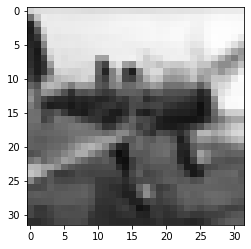

In [278]:
plt.imshow(y)

In [285]:
img = cv2.imread('0.png')
img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(img_lab)

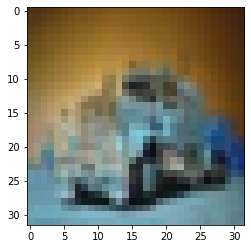

In [322]:
l = l/255
plt.imshow(img)